# Simple explainability of image-text similarity with CLIP-ViT and Hugging Face

Given an image and text description like this adorable kitten...

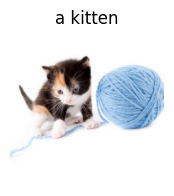

In [1]:
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open('kitten.jpg')
prompt = "a kitten"
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(img)
ax.set_title(prompt)
ax.axis('off');

...how can we tell which region in the image is relevant to the text? OpenAI's multimodal (vision & language) [CLIP model](https://openai.com/research/clip) along with transformer attention-based explainability makes this easy! Let's use the method from [Chefer et al. (ICCV 2021)](https://arxiv.org/abs/2103.15679) ([GitHub](https://github.com/hila-chefer/Transformer-MM-Explainability)) to try this ourselves.

First we load CLIP.

In [2]:
from transformers import CLIPProcessor, CLIPModel

processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

Then we write a few lines of code to implement the method in its simplest form:

In [3]:
import torch

def interpret(img, prompt):
    inp = processor(
        text=[prompt],
        images=img,
        return_tensors="pt",
    )
    out = model(**inp, output_attentions=True)
    model.zero_grad()    
    logit = out.logits_per_image[0, 0]
    A = out.vision_model_output.attentions[-1]
    grad = torch.autograd.grad(logit, A)[0].detach()
    return (grad[0, :, 0, 1:] * A.detach()[0, :, 0, 1:]).clamp(min=0).mean(dim=0)

R = interpret(img, prompt)

This uses the attention weights and gradients of the last self-attention layer of CLIP's vision encoder, evaluating which areas are most relevant to the final similarity to the text prompt's embedding.

Finally, let's scale the relevancy map so it looks attractive, and visualize it:

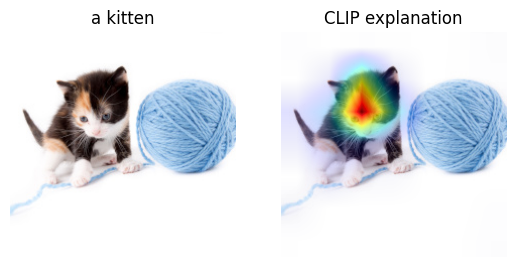

In [4]:
import cv2

heatmap  = torch.nn.functional.interpolate(R.reshape(1, 1, 7, 7), size=224, mode='bilinear')[0, 0].numpy()
heatmap -= heatmap.min()
heatmap /= heatmap.max()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[0].set_title(prompt)
axs[1].imshow(img)
axs[1].imshow(heatmap, alpha=heatmap, cmap='jet')
axs[1].set_title('CLIP explanation')
for ax in axs:
    ax.axis('off')

Voilà! CLIP attends to the kitten (particularly its face) and ignores the yarn ball.

Note that this example uses a single self-attention layer alone, but this code be easily adapted to aggregate scores across multiple self-attention layers as described by Chefer et al. and illustrated in [their code repository](https://github.com/hila-chefer/Transformer-MM-Explainability).